# 전처리 조합(순열) 성능 비교

7가지 전처리 방식을 1개, 2개, 3개씩 조합하여 순열로 적용한 후 Decision Tree와 Random Forest 모델 성능을 비교합니다.
가우시안 블러가 개별적으로 가장 좋은 성능을 보였으므로, 이를 포함한 조합들을 중심으로 분석합니다.

## 라이브러리 불러오기

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from itertools import permutations, combinations
from tqdm import tqdm
import warnings
import time
import random
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

## 전처리 함수 정의

In [2]:
def preprocess_none(img):
    return cv2.resize(img, (100, 100))

def preprocess_clahe(img):
    img = cv2.resize(img, (100, 100))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def preprocess_gamma(img, gamma=1.5):
    img = cv2.resize(img, (100, 100))
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                     for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def preprocess_hsv_boost(img, delta=40):
    img = cv2.resize(img, (100, 100))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] + delta, 0, 255)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def preprocess_sharpen(img):
    img = cv2.resize(img, (100, 100))
    blur = cv2.GaussianBlur(img, (0, 0), 3)
    return cv2.addWeighted(img, 1.5, blur, -0.5, 0)

def preprocess_gaussian_blur(img):
    img = cv2.resize(img, (100, 100))
    return cv2.GaussianBlur(img, (5, 5), 1)

def preprocess_circle_detect(img):
    img = cv2.resize(img, (100, 100))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=5, maxRadius=40)
    output = img.copy()
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)
    return output

## 특징 추출 함수

In [3]:
def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 밝기 관련 특징
    avg_brightness = np.mean(gray)
    max_brightness = np.max(gray)
    std_brightness = np.std(gray)

    # RGB 평균값
    avg_b, avg_g, avg_r = cv2.mean(image)[:3]

    # 색상 비율 계산
    def mask_ratio(hsv_img, lower, upper):
        mask = cv2.inRange(hsv_img, lower, upper)
        return np.count_nonzero(mask) / (mask.size + 1e-6)

    green_ratio = mask_ratio(hsv, (40, 50, 50), (85, 255, 255))
    yellow_ratio = mask_ratio(hsv, (20, 50, 50), (35, 255, 255))
    red_ratio = (
        mask_ratio(hsv, (0, 50, 50), (10, 255, 255)) +
        mask_ratio(hsv, (160, 50, 50), (180, 255, 255))
    )

    # 엣지 관련 특징
    edges = cv2.Canny(gray, 100, 200)
    edge_count = np.count_nonzero(edges)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_area = sum(cv2.contourArea(c) for c in contours)

    # HSV 평균값
    hue_mean = np.mean(hsv[:, :, 0])
    saturation_mean = np.mean(hsv[:, :, 1])
    value_mean = np.mean(hsv[:, :, 2])

    return [
        avg_brightness, max_brightness, std_brightness,
        avg_r, avg_g, avg_b,
        green_ratio, yellow_ratio, red_ratio,
        edge_count, contour_area,
        hue_mean, saturation_mean, value_mean
    ]

## 조합 전처리 함수

In [4]:
# 전처리 함수 매핑
preprocess_functions = {
    'none': preprocess_none,
    'clahe': preprocess_clahe,
    'gamma': preprocess_gamma,
    'hsv_boost': preprocess_hsv_boost,
    'sharpen': preprocess_sharpen,
    'gaussian_blur': preprocess_gaussian_blur,
    'circle_detect': preprocess_circle_detect
}

def apply_combination_preprocessing(img, combination):
    """
    여러 전처리를 순서대로 적용
    combination: 전처리 방법들의 튜플 (순서 중요)
    """
    result = img.copy()
    for method in combination:
        if method in preprocess_functions:
            result = preprocess_functions[method](result)
    return result

## 데이터 로드 및 조합 생성

In [5]:
# 데이터 경로 설정
data_dir = 'label'  # 실제 경로에 맞게 수정
label_map = {'off': 0, 'green': 1, 'yellow': 2, 'red': 3}

# 전처리 방법들 (none 제외)
methods = ['clahe', 'gamma', 'hsv_boost', 'sharpen', 'gaussian_blur', 'circle_detect']

# 모든 순열 조합 생성 (1개부터 6개까지)
all_combinations = []

print("순열 조합 생성 중...")
for r in range(1, len(methods) + 1):  # 1개부터 6개까지
    perms = list(permutations(methods, r))
    all_combinations.extend(perms)
    print(f"{r}개 순열: {len(perms)}개 조합")

print(f"\n총 순열 조합 수: {len(all_combinations)}")
print(f"예상 실행 시간: 약 {len(all_combinations) * 0.5:.0f}분 (조합당 30초 가정)")

print("\n처음 10개 조합:")
for i, combo in enumerate(all_combinations[:10]):
    print(f"{i+1}: {' -> '.join(combo)}")

print("\n마지막 10개 조합:")
for i, combo in enumerate(all_combinations[-10:]):
    print(f"{len(all_combinations)-9+i}: {' -> '.join(combo)}")

# 계산량이 많으므로 사용자 확인
print(f"\n⚠️  총 {len(all_combinations)}개의 조합을 모두 테스트하면 상당한 시간이 걸립니다.")
print("실행을 계속하시겠습니까? (다음 셀을 실행하기 전에 확인해 주세요)")

# 조합 개수별 통계
combination_stats = {}
for combo in all_combinations:
    length = len(combo)
    combination_stats[length] = combination_stats.get(length, 0) + 1

print("\n조합 개수별 통계:")
for length in sorted(combination_stats.keys()):
    print(f"  {length}개 조합: {combination_stats[length]}개")

순열 조합 생성 중...
1개 순열: 6개 조합
2개 순열: 30개 조합
3개 순열: 120개 조합
4개 순열: 360개 조합
5개 순열: 720개 조합
6개 순열: 720개 조합

총 순열 조합 수: 1956
예상 실행 시간: 약 978분 (조합당 30초 가정)

처음 10개 조합:
1: clahe
2: gamma
3: hsv_boost
4: sharpen
5: gaussian_blur
6: circle_detect
7: clahe -> gamma
8: clahe -> hsv_boost
9: clahe -> sharpen
10: clahe -> gaussian_blur

마지막 10개 조합:
1947: circle_detect -> gaussian_blur -> hsv_boost -> gamma -> clahe -> sharpen
1948: circle_detect -> gaussian_blur -> hsv_boost -> gamma -> sharpen -> clahe
1949: circle_detect -> gaussian_blur -> hsv_boost -> sharpen -> clahe -> gamma
1950: circle_detect -> gaussian_blur -> hsv_boost -> sharpen -> gamma -> clahe
1951: circle_detect -> gaussian_blur -> sharpen -> clahe -> gamma -> hsv_boost
1952: circle_detect -> gaussian_blur -> sharpen -> clahe -> hsv_boost -> gamma
1953: circle_detect -> gaussian_blur -> sharpen -> gamma -> clahe -> hsv_boost
1954: circle_detect -> gaussian_blur -> sharpen -> gamma -> hsv_boost -> clahe
1955: circle_detect -> gaussian_

## 모델 평가 함수

In [6]:
def evaluate_combination(image_data, combination):
    """
    특정 조합의 전처리를 적용하여 모델 성능 평가
    """
    # 조합 전처리 적용 및 특징 추출
    features_list = []
    labels_list = []
    
    print(f"    🔄 이미지 처리 중... (총 {len(image_data)}개)")
    processed_count = 0
    
    for img_path, label in image_data:
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        # 조합 전처리 적용
        processed_img = apply_combination_preprocessing(img, combination)
        
        # 특징 추출
        features = extract_features(processed_img)
        features_list.append(features)
        labels_list.append(label)
        
        processed_count += 1
        if processed_count % 50 == 0:  # 50개마다 진행 상황 출력
            print(f"    📊 이미지 처리: {processed_count}/{len(image_data)} ({processed_count/len(image_data)*100:.1f}%)")
    
    print(f"    🔄 특징 추출 완료: {len(features_list)}개 이미지")
    
    # DataFrame 생성
    feature_columns = [f'feature_{i}' for i in range(len(features_list[0]))]
    df = pd.DataFrame(features_list, columns=feature_columns)
    df['label'] = labels_list
    
    print(f"    🔄 데이터 분할 중...")
    # 데이터 분할
    X = df.drop(columns=['label'])
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    print(f"    🌳 Decision Tree 학습 중...")
    # Decision Tree
    dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
    dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    dt_acc = accuracy_score(y_test, dt_pred)
    dt_f1 = f1_score(y_test, dt_pred, average='macro')

    print(f"    🌲 Random Forest 학습 중...")
    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred, average='macro')

    return {
        'combination': ' -> '.join(combination),
        'combination_tuple': combination,
        'dt_accuracy': dt_acc,
        'dt_f1': dt_f1,
        'rf_accuracy': rf_acc,
        'rf_f1': rf_f1,
        'num_methods': len(combination)
    }

## 이미지 데이터 로드

In [7]:
# 이미지 파일 경로와 라벨 수집
image_data = []

for label_name in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label_name)
    if not os.path.isdir(label_path) or label_name not in label_map:
        continue
    
    label = label_map[label_name]
    
    for fname in os.listdir(label_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            fpath = os.path.join(label_path, fname)
            image_data.append((fpath, label))

print(f"총 이미지 수: {len(image_data)}")
print(f"라벨별 분포:")
label_counts = {}
for _, label in image_data:
    label_counts[label] = label_counts.get(label, 0) + 1

label_names = ['off', 'green', 'yellow', 'red']
for i, name in enumerate(label_names):
    print(f"  {name}: {label_counts.get(i, 0)}")

총 이미지 수: 108
라벨별 분포:
  off: 27
  green: 27
  yellow: 27
  red: 27


## 조합별 성능 평가 실행

In [8]:
# 🚀 전체 순열 조합 성능 평가 실행 (1,956개 모든 조합)
results = []

# ===== 💻 컴퓨터 설정 (주석 처리로 변경) =====
# 👇 컴퓨터 1번용 설정 (기본값)
COMPUTER_ID = 1
TOTAL_COMPUTERS = 2

# 👇 컴퓨터 2번용 설정 (2번 컴퓨터에서는 위 2줄을 주석처리하고 아래 2줄의 주석을 해제)
# COMPUTER_ID = 2
# TOTAL_COMPUTERS = 2

print(f"🖥️ 현재 설정: 컴퓨터 {COMPUTER_ID}번")
print(f"💡 컴퓨터 2번에서 실행하려면 위의 COMPUTER_ID 설정을 주석으로 변경하세요!")
print("-" * 60)

# 모든 조합 테스트 설정
FULL_TEST = True
SAVE_INTERVAL = 10  # 10개마다 중간 저장
RESTART_SAFE = True  # 중단 시 재시작 가능

print(f"🚀 컴퓨터 {COMPUTER_ID}/{TOTAL_COMPUTERS}번으로 순열 조합을 테스트합니다!")
print(f"총 조합 수: {len(all_combinations)}")

# 조합을 컴퓨터별로 분할
total_combinations = len(all_combinations)
chunk_size = total_combinations // TOTAL_COMPUTERS
start_idx = (COMPUTER_ID - 1) * chunk_size
if COMPUTER_ID == TOTAL_COMPUTERS:  # 마지막 컴퓨터는 나머지까지 처리
    end_idx = total_combinations
else:
    end_idx = start_idx + chunk_size

assigned_combinations = all_combinations[start_idx:end_idx]

print(f"📊 컴퓨터 {COMPUTER_ID} 할당 범위: {start_idx+1}~{end_idx} ({len(assigned_combinations)}개 조합)")
print("예상 소요 시간: 약 8-10시간")
print("💾 10개마다 자동 저장되며, 중단 시 재시작 가능합니다.")
print("=" * 80)

# 안전한 파일 저장 함수 정의
def safe_save_csv(df, base_filename):
    """여러 경로에 안전하게 CSV 파일 저장"""
    import os
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{base_filename}_PC{COMPUTER_ID}_{timestamp}.csv"
    
    # 시도할 저장 경로들 (우선순위 순)
    save_paths = [
        filename,  # 현재 디렉토리
        os.path.join(os.getcwd(), filename),  # 명시적 현재 경로
        os.path.join(os.path.expanduser("~"), "Desktop", filename),  # 바탕화면
        os.path.join(os.path.expanduser("~"), "Documents", filename),  # 문서
        os.path.join("C:\\", "temp", filename),  # C:\temp
        os.path.join("D:\\", filename) if os.path.exists("D:\\") else None  # D 드라이브
    ]
    
    # None 제거
    save_paths = [path for path in save_paths if path is not None]
    
    for path in save_paths:
        try:
            # 디렉토리가 없으면 생성
            dir_path = os.path.dirname(path)
            if dir_path and not os.path.exists(dir_path):
                os.makedirs(dir_path, exist_ok=True)
            
            df.to_csv(path, index=False, encoding='utf-8-sig')
            print(f"  📁 저장 성공: {path}")
            return path
            
        except Exception as e:
            print(f"  ❌ 저장 실패 ({path}): {e}")
            continue
    
    print(f"  ⚠️  모든 경로에서 저장 실패!")
    return None

# 기존 중간 결과 파일 확인 및 로드
existing_results = []
import glob
import datetime

if RESTART_SAFE:
    # 현재 컴퓨터의 중간 결과 파일만 찾기
    temp_files = glob.glob(f'temp_results_*_PC{COMPUTER_ID}_*.csv')
    if not temp_files:
        # 기존 형식도 확인
        temp_files = glob.glob('temp_results_*.csv')
    
    if temp_files:
        print(f"🔄 기존 중간 결과 파일 {len(temp_files)}개 발견")
        latest_file = max(temp_files, key=lambda x: os.path.getctime(x))
        try:
            existing_df = pd.read_csv(latest_file)
            existing_results = existing_df.to_dict('records')
            print(f"📂 기존 결과 {len(existing_results)}개 로드: {latest_file}")
            
            # 이미 처리된 조합들 제외
            processed_combinations = set(existing_df['combination'].values)
            remaining_combinations = [combo for combo in assigned_combinations 
                                    if ' -> '.join(combo) not in processed_combinations]
            print(f"✅ 남은 조합 수: {len(remaining_combinations)}")
        except Exception as e:
            print(f"⚠️  기존 결과 로드 실패: {e}")
            remaining_combinations = assigned_combinations
    else:
        remaining_combinations = assigned_combinations
        print("🆕 새로운 실행을 시작합니다.")
else:
    remaining_combinations = assigned_combinations

# 결과 리스트 초기화
results = existing_results.copy()
start_index = len(results)

# 성능 평가 실행
print(f"\n조합별 성능 평가 시작... (시작 인덱스: {start_index})")
overall_start_time = time.time()

for i, combination in enumerate(remaining_combinations):
    current_index = start_index + i + 1
    global_index = start_idx + current_index  # 전체에서의 인덱스
    print(f"\n[{current_index}/{len(assigned_combinations)}] (전체: {global_index}/{total_combinations}) 평가 중: {' -> '.join(combination)}")
    
    try:
        start_time = time.time()
        result = evaluate_combination(image_data, combination)
        elapsed = time.time() - start_time
        
        # 컴퓨터 ID와 글로벌 인덱스 추가
        result['computer_id'] = COMPUTER_ID
        result['global_index'] = global_index
        results.append(result)
        
        print(f"  ✅ 완료 ({elapsed:.1f}초)")
        print(f"     Decision Tree - Accuracy: {result['dt_accuracy']:.4f}, F1: {result['dt_f1']:.4f}")
        print(f"     Random Forest - Accuracy: {result['rf_accuracy']:.4f}, F1: {result['rf_f1']:.4f}")
        
        # 중간 결과 저장 (SAVE_INTERVAL개마다)
        if current_index % SAVE_INTERVAL == 0:
            overall_elapsed = time.time() - overall_start_time
            avg_time_per_combo = overall_elapsed / (i + 1)
            remaining_combos = len(assigned_combinations) - current_index
            estimated_remaining = (remaining_combos * avg_time_per_combo) / 3600  # 시간 단위
            
            print(f"  💾 중간 저장... 진행률: {current_index/len(assigned_combinations)*100:.1f}%")
            print(f"  ⏱️  경과: {overall_elapsed/3600:.1f}시간, 평균: {avg_time_per_combo:.1f}초/조합")
            print(f"  📊 예상 남은 시간: {estimated_remaining:.1f}시간")
            
            # 중간 결과 저장
            temp_df = pd.DataFrame(results)
            saved_path = safe_save_csv(temp_df, f'temp_results_{current_index}')
            
            if saved_path:
                # 현재까지의 최고 성능 출력
                temp_df_sorted = temp_df.sort_values('rf_f1', ascending=False)
                current_best = temp_df_sorted.iloc[0]
                print(f"  🏆 현재 최고: {current_best['combination']} (F1: {current_best['rf_f1']:.4f})")
        
        # 메모리 정리 (100개마다)
        if current_index % 100 == 0:
            import gc
            gc.collect()
            print(f"  🧹 메모리 정리 완료")
            
    except KeyboardInterrupt:
        print(f"\n⏸️  사용자에 의해 중단됨 (진행률: {current_index/len(assigned_combinations)*100:.1f}%)")
        print("현재까지의 결과는 저장됩니다.")
        break
        
    except Exception as e:
        print(f"  ❌ 오류 발생: {e}")
        print(f"     조합 건너뛰기: {' -> '.join(combination)}")
        continue

# 실행 완료 정리
elapsed_total = time.time() - overall_start_time
completed_count = len(results) - len(existing_results)

print(f"\n" + "="*80)
print(f"✅ 컴퓨터 {COMPUTER_ID} 평가 완료!")
print(f"📊 총 결과: {len(results)}개 조합 (신규 처리: {completed_count}개)")
print(f"⏱️  총 소요 시간: {elapsed_total/3600:.1f}시간 ({elapsed_total/60:.0f}분)")
if completed_count > 0:
    print(f"⚡ 평균 처리 시간: {elapsed_total/completed_count:.1f}초/조합")

# 최종 결과 저장
if results:
    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values('rf_f1', ascending=False)
    
    # 최종 파일 저장
    final_path = safe_save_csv(df_results, f'preprocessing_combination_results_FINAL')
    
    if final_path:
        print(f"📁 최종 결과 저장 완료!")
    else:
        print("⚠️  최종 저장 실패 - 결과는 df_results 변수에 저장되어 있습니다.")
        
    # 최종 요약
    print(f"\n🏆 컴퓨터 {COMPUTER_ID} 최종 결과 요약:")
    print(f"  최고 성능: {df_results.iloc[0]['combination']}")
    print(f"  최고 F1 점수: {df_results.iloc[0]['rf_f1']:.4f}")
    print(f"  최고 정확도: {df_results.iloc[0]['rf_accuracy']:.4f}")
    
    # 상위 5개 조합 출력
    print(f"\n🥇 상위 5개 조합:")
    for i, (_, row) in enumerate(df_results.head(5).iterrows()):
        print(f"  {i+1}. {row['combination']} (F1: {row['rf_f1']:.4f})")
        
    # 길이별 최고 성능
    print(f"\n📈 길이별 최고 성능:")
    for length in sorted(df_results['num_methods'].unique()):
        subset = df_results[df_results['num_methods'] == length]
        best = subset.iloc[0]
        print(f"  {length}개: {best['combination']} (F1: {best['rf_f1']:.4f})")
        
else:
    print("❌ 결과가 없습니다.")

print(f"\n🎉 컴퓨터 {COMPUTER_ID} 순열 분석 완료!")
print(f"📋 처리 범위: {start_idx+1}~{end_idx} ({len(assigned_combinations)}개 조합)")
print("💡 다른 컴퓨터 결과와 합치려면 결과 합치기 셀을 실행하세요.")

🖥️ 현재 설정: 컴퓨터 1번
💡 컴퓨터 2번에서 실행하려면 위의 COMPUTER_ID 설정을 주석으로 변경하세요!
------------------------------------------------------------
🚀 컴퓨터 1/2번으로 순열 조합을 테스트합니다!
총 조합 수: 1956
📊 컴퓨터 1 할당 범위: 1~978 (978개 조합)
예상 소요 시간: 약 8-10시간
💾 10개마다 자동 저장되며, 중단 시 재시작 가능합니다.
🆕 새로운 실행을 시작합니다.

조합별 성능 평가 시작... (시작 인덱스: 0)

[1/978] (전체: 1/1956) 평가 중: clahe
    🔄 이미지 처리 중... (총 108개)
    📊 이미지 처리: 50/108 (46.3%)
    📊 이미지 처리: 100/108 (92.6%)
    🔄 특징 추출 완료: 108개 이미지
    🔄 데이터 분할 중...
    🌳 Decision Tree 학습 중...
    🌲 Random Forest 학습 중...
    📊 이미지 처리: 50/108 (46.3%)
    📊 이미지 처리: 100/108 (92.6%)
    🔄 특징 추출 완료: 108개 이미지
    🔄 데이터 분할 중...
    🌳 Decision Tree 학습 중...
    🌲 Random Forest 학습 중...
  ✅ 완료 (0.4초)
     Decision Tree - Accuracy: 0.8182, F1: 0.8036
     Random Forest - Accuracy: 0.9091, F1: 0.9083

[2/978] (전체: 2/1956) 평가 중: gamma
    🔄 이미지 처리 중... (총 108개)
    📊 이미지 처리: 50/108 (46.3%)
    📊 이미지 처리: 100/108 (92.6%)
    🔄 특징 추출 완료: 108개 이미지
    🔄 데이터 분할 중...
    🌳 Decision Tree 학습 중...
    🌲 Random Forest 학습

In [ ]:
# 🔗 두 컴퓨터 결과 합치기
print("🔗 두 컴퓨터 결과를 합칩니다...")

import glob
import pandas as pd

# 각 컴퓨터별 최종 결과 파일 찾기
pc1_files = glob.glob('preprocessing_combination_results_FINAL_PC1_*.csv')
pc2_files = glob.glob('preprocessing_combination_results_FINAL_PC2_*.csv')

print(f"📂 컴퓨터 1 파일: {len(pc1_files)}개")
print(f"📂 컴퓨터 2 파일: {len(pc2_files)}개")

all_results = []

# 컴퓨터 1 결과 로드
if pc1_files:
    latest_pc1 = max(pc1_files, key=lambda x: os.path.getctime(x))
    print(f"📥 컴퓨터 1 결과 로드: {latest_pc1}")
    df_pc1 = pd.read_csv(latest_pc1)
    all_results.append(df_pc1)
    print(f"   └─ {len(df_pc1)}개 조합")
else:
    print("⚠️  컴퓨터 1 결과 파일을 찾을 수 없습니다.")

# 컴퓨터 2 결과 로드
if pc2_files:
    latest_pc2 = max(pc2_files, key=lambda x: os.path.getctime(x))
    print(f"📥 컴퓨터 2 결과 로드: {latest_pc2}")
    df_pc2 = pd.read_csv(latest_pc2)
    all_results.append(df_pc2)
    print(f"   └─ {len(df_pc2)}개 조합")
else:
    print("⚠️  컴퓨터 2 결과 파일을 찾을 수 없습니다.")

# 결과 합치기
if len(all_results) >= 2:
    print("\n🔀 결과 합치는 중...")
    combined_df = pd.concat(all_results, ignore_index=True)
    
    # 중복 제거 (혹시 있을 경우)
    original_count = len(combined_df)
    combined_df = combined_df.drop_duplicates(subset=['combination'], keep='first')
    deduplicated_count = len(combined_df)
    
    if original_count != deduplicated_count:
        print(f"⚠️  중복 제거: {original_count - deduplicated_count}개")
    
    # 성능순으로 정렬
    combined_df = combined_df.sort_values('rf_f1', ascending=False)
    
    print(f"✅ 합치기 완료! 총 {len(combined_df)}개 조합")
    
    # 최종 통합 결과 저장
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    final_filename = f'preprocessing_combination_results_COMBINED_{timestamp}.csv'
    
    # 안전한 저장
    save_paths = [
        final_filename,
        os.path.join(os.path.expanduser("~"), "Desktop", final_filename),
        os.path.join(os.path.expanduser("~"), "Documents", final_filename)
    ]
    
    saved = False
    for path in save_paths:
        try:
            combined_df.to_csv(path, index=False, encoding='utf-8-sig')
            print(f"📁 통합 결과 저장: {path}")
            saved = True
            break
        except Exception as e:
            print(f"❌ 저장 실패 ({path}): {e}")
            continue
    
    if not saved:
        print("⚠️  파일 저장 실패 - 결과는 combined_df 변수에 저장됨")
    
    # 통합 결과 요약
    print(f"\n🏆 전체 최종 결과 요약:")
    print(f"   총 조합 수: {len(combined_df)} / {len(all_combinations)} ({len(combined_df)/len(all_combinations)*100:.1f}%)")
    print(f"   최고 성능: {combined_df.iloc[0]['combination']}")
    print(f"   최고 F1 점수: {combined_df.iloc[0]['rf_f1']:.4f}")
    print(f"   최고 정확도: {combined_df.iloc[0]['rf_accuracy']:.4f}")
    
    # 컴퓨터별 기여도
    print(f"\n📊 컴퓨터별 기여도:")
    pc_stats = combined_df['computer_id'].value_counts().sort_index()
    for pc_id, count in pc_stats.items():
        print(f"   컴퓨터 {pc_id}: {count}개 조합 ({count/len(combined_df)*100:.1f}%)")
    
    # 상위 10개 조합
    print(f"\n🥇 통합 상위 10개 조합:")
    for i, (_, row) in enumerate(combined_df.head(10).iterrows()):
        pc_id = row.get('computer_id', 'N/A')
        print(f"   {i+1}. {row['combination']} (F1: {row['rf_f1']:.4f}) [PC{pc_id}]")
    
    # 길이별 최고 성능
    print(f"\n📈 길이별 최고 성능:")
    for length in sorted(combined_df['num_methods'].unique()):
        subset = combined_df[combined_df['num_methods'] == length]
        best = subset.iloc[0]
        pc_id = best.get('computer_id', 'N/A')
        print(f"   {length}개: {best['combination']} (F1: {best['rf_f1']:.4f}) [PC{pc_id}]")
    
    # 전역 변수로 저장
    df_results = combined_df
    print(f"\n💾 통합 결과가 df_results 변수에 저장되었습니다.")
    
elif len(all_results) == 1:
    print(f"\n⚠️  한 대의 컴퓨터 결과만 있습니다. ({len(all_results[0])}개 조합)")
    df_results = all_results[0]
    
else:
    print("\n❌ 결과 파일을 찾을 수 없습니다.")
    print("각 컴퓨터에서 실행이 완료되었는지 확인해 주세요.")

print("\n🎉 결과 합치기 완료!")

# 🖥️ 2대 컴퓨터 실행 가이드

## 📋 실행 순서

### 1️⃣ 준비 작업 (양쪽 컴퓨터 모두)
- 이 노트북을 각 컴퓨터에 복사
- 데이터 폴더(`label/`) 동일하게 복사
- 필요한 라이브러리 설치 확인

### 2️⃣ 실행 방법

**컴퓨터 1번:**
- 위의 "전체 순열 조합 성능 평가 실행" 셀 실행
- `COMPUTER_ID = 1`이 설정되어 있음
- 1~978번 조합 처리 (전체의 50%)

**컴퓨터 2번:**
- "컴퓨터 2번 전용" 셀 실행  
- `COMPUTER_ID = 2`가 설정되어 있음
- 979~1956번 조합 처리 (전체의 50%)

### 3️⃣ 결과 합치기
- 두 컴퓨터 실행 완료 후
- "두 컴퓨터 결과 합치기" 셀 실행
- 통합된 최종 결과 확인

## 🔧 주요 개선사항

### CSV 저장 문제 해결:
- **다중 경로 시도**: 현재 폴더 → 바탕화면 → 문서 → C:\temp → D:\ 순으로 시도
- **타임스탬프 파일명**: 중복 방지를 위한 고유 파일명
- **UTF-8-BOM 인코딩**: 한글 호환성 향상
- **디렉토리 자동 생성**: 없는 폴더는 자동으로 생성

### 컴퓨터별 분할:
- **정확한 50:50 분할**: 1,956개 조합을 978개씩 분할
- **컴퓨터 ID 추가**: 결과에 어느 컴퓨터에서 처리했는지 기록
- **독립적 중간저장**: 각 컴퓨터별로 별도 파일명 사용
- **재시작 안전성**: 각각 독립적으로 재시작 가능

## ⚠️ 주의사항

1. **동시 실행**: 두 컴퓨터에서 동시에 실행해야 효율적
2. **파일명 확인**: PC1, PC2가 파일명에 포함되는지 확인
3. **중간 저장**: 10개마다 자동 저장되므로 파일 확인
4. **메모리 관리**: 100개마다 자동 메모리 정리

## 📊 예상 결과

- **총 실행시간**: 각 컴퓨터당 8-10시간 (동시 실행시)
- **저장 파일**: 
  - `temp_results_*_PC1_*.csv` (컴퓨터 1 중간 결과)
  - `temp_results_*_PC2_*.csv` (컴퓨터 2 중간 결과)
  - `preprocessing_combination_results_FINAL_PC1_*.csv` (컴퓨터 1 최종)
  - `preprocessing_combination_results_FINAL_PC2_*.csv` (컴퓨터 2 최종)
  - `preprocessing_combination_results_COMBINED_*.csv` (통합 최종)

## 🚀 바로 실행하기

**컴퓨터 1**: 위의 37번 셀 실행  
**컴퓨터 2**: 바로 아래 38번 셀 실행

In [ ]:
# ⏱️ 실행 시간 예측 계산기
import math

print("🕐 실행 시간 예측 분석")
print("=" * 60)

# 기본 데이터
total_combinations = 1956
methods_count = 6

# 조합 개수별 분포
combination_breakdown = {
    1: 6,    # 6P1 = 6
    2: 30,   # 6P2 = 6*5 = 30
    3: 120,  # 6P3 = 6*5*4 = 120
    4: 360,  # 6P4 = 6*5*4*3 = 360
    5: 720,  # 6P5 = 6*5*4*3*2 = 720
    6: 720   # 6P6 = 6*5*4*3*2*1 = 720
}

print(f"📊 순열 조합 구성:")
total_check = 0
for length, count in combination_breakdown.items():
    total_check += count
    print(f"   {length}개 방법 순열: {count:,}개")
print(f"   ─────────────────────")
print(f"   총합: {total_check:,}개 조합")

# 조합당 예상 처리 시간 (여러 시나리오)
print(f"\n⏱️  조합당 처리 시간 시나리오:")

# 시나리오별 시간 계산
scenarios = {
    "빠른 경우 (20초/조합)": 20,
    "보통 경우 (30초/조합)": 30,
    "느린 경우 (45초/조합)": 45,
    "매우 느린 경우 (60초/조합)": 60
}

for scenario_name, seconds_per_combo in scenarios.items():
    total_seconds = total_combinations * seconds_per_combo
    total_minutes = total_seconds / 60
    total_hours = total_minutes / 60
    
    print(f"   {scenario_name}: {total_hours:.1f}시간 ({total_minutes:.0f}분)")

print(f"\n🖥️ 컴퓨터별 실행 시간 비교:")
print("─" * 50)

# 1대 vs 2대 비교
print("📍 시나리오: 보통 경우 (30초/조합) 기준")
base_seconds_per_combo = 30
total_base_hours = (total_combinations * base_seconds_per_combo) / 3600

print(f"\n🖥️ 컴퓨터 1대로 실행:")
print(f"   • 총 조합: {total_combinations:,}개")
print(f"   • 예상 시간: {total_base_hours:.1f}시간 ({total_base_hours*60:.0f}분)")
print(f"   • 일 기준: {total_base_hours/24:.1f}일")

# 2대 분할 계산
pc1_combinations = total_combinations // 2  # 978개
pc2_combinations = total_combinations - pc1_combinations  # 978개

pc1_hours = (pc1_combinations * base_seconds_per_combo) / 3600
pc2_hours = (pc2_combinations * base_seconds_per_combo) / 3600

print(f"\n🖥️🖥️ 컴퓨터 2대로 동시 실행:")
print(f"   • 컴퓨터 1: {pc1_combinations:,}개 조합 → {pc1_hours:.1f}시간")
print(f"   • 컴퓨터 2: {pc2_combinations:,}개 조합 → {pc2_hours:.1f}시간")
print(f"   • 동시 실행 완료 시간: {max(pc1_hours, pc2_hours):.1f}시간")
print(f"   • 시간 단축 효과: {total_base_hours - max(pc1_hours, pc2_hours):.1f}시간 단축")
print(f"   • 효율성: {(total_base_hours / max(pc1_hours, pc2_hours)):.1f}배 빨라짐")

# 실제 처리 복잡도 분석
print(f"\n🔍 처리 복잡도 분석:")
print(f"   • 조합별 처리 단계:")
print(f"     1. 이미지 로드 및 전처리 순열 적용 (~10-15초)")
print(f"     2. 특징 추출 (14개 특징) (~5-8초)")
print(f"     3. 모델 학습 (Decision Tree + Random Forest) (~8-12초)")
print(f"     4. 성능 평가 및 결과 저장 (~2-5초)")
print(f"     ──────────────────────────────────")
print(f"     총 예상: 25-40초/조합")

# 현실적 시간 예측
realistic_scenarios = {
    "최적 환경 (고성능 CPU)": 25,
    "일반 환경 (중급 CPU)": 35,
    "저사양 환경 (저급 CPU)": 50
}

print(f"\n🎯 현실적 시간 예측:")
for env_name, seconds in realistic_scenarios.items():
    one_pc_hours = (total_combinations * seconds) / 3600
    two_pc_hours = (pc1_combinations * seconds) / 3600
    
    print(f"\n   {env_name}:")
    print(f"     • 1대: {one_pc_hours:.1f}시간 ({one_pc_hours/24:.1f}일)")
    print(f"     • 2대: {two_pc_hours:.1f}시간 ({two_pc_hours/24:.1f}일)")
    
    if one_pc_hours > 24:
        print(f"     ⚠️  1대 실행시 24시간 초과 - 2대 권장!")

# 권장사항
print(f"\n💡 권장사항:")
print(f"   ✅ 2대 컴퓨터 동시 실행 강력 권장")
print(f"   ✅ 예상 완료 시간: 8-14시간 (환경에 따라)")
print(f"   ✅ 밤사이 실행 가능한 현실적 시간")
print(f"   ⚠️  1대로 실행시 16-27시간 소요 (1일 초과)")

# 저장 용량 계산
print(f"\n💾 저장 공간 예상:")
result_size_per_combo = 0.5  # KB
total_storage_mb = (total_combinations * result_size_per_combo) / 1024
print(f"   • 최종 결과 파일: 약 {total_storage_mb:.1f}MB")
print(f"   • 중간 저장 파일들: 약 {total_storage_mb * 2:.1f}MB")
print(f"   • 총 필요 공간: 약 {total_storage_mb * 3:.1f}MB")

print(f"\n🎉 결론: 2대 컴퓨터로 나눠서 하는게 훨씬 효율적!")
print(f"   ⏰ 시간: {total_base_hours:.0f}시간 → {max(pc1_hours, pc2_hours):.0f}시간 (약 {total_base_hours - max(pc1_hours, pc2_hours):.0f}시간 단축)")
print(f"   💪 효율: {(total_base_hours / max(pc1_hours, pc2_hours)):.1f}배 빨라짐")

# 🚀 2대 컴퓨터 실행 가이드 (주석 처리 방식)

## 📋 사용법 (매우 간단!)

### 🖥️ **컴퓨터 1번 (현재 컴퓨터)**
1. **아무것도 수정하지 말고** 37번 셀 그대로 실행
2. `COMPUTER_ID = 1`로 설정되어 있음 (1~978번 조합 처리)

### ?️ **컴퓨터 2번 (다른 팀원)**
1. **이 노트북 파일 복사**
2. **`label/` 폴더 전체 복사** 
3. **37번 셀에서 주석 수정:**
   ```python
   # 👇 컴퓨터 1번용 설정 (기본값) - 이 2줄을 주석처리
   # COMPUTER_ID = 1
   # TOTAL_COMPUTERS = 2
   
   # 👇 컴퓨터 2번용 설정 - 이 2줄의 주석을 해제
   COMPUTER_ID = 2
   TOTAL_COMPUTERS = 2
   ```
4. **수정된 37번 셀 실행** (979~1956번 조합 처리)

### ? **결과 합치기**
- 두 컴퓨터 완료 후 38번 셀 실행

## 📁 **복사할 파일들**
```
📁 작업폴더/
   ├── LED_Model_Combination_Preprocessing.ipynb  ← 이 파일
   └── label/                                      ← 전체 폴더
       ├── off/ (모든 .jpg 파일들)
       ├── green/ (모든 .jpg 파일들)
       ├── yellow/ (모든 .jpg 파일들)
       └── red/ (모든 .jpg 파일들)
```

## 🎯 **실행 예시**

### 컴퓨터 1번에서 실행 시:
```
🖥️ 현재 설정: 컴퓨터 1번
💡 컴퓨터 2번에서 실행하려면 위의 COMPUTER_ID 설정을 주석으로 변경하세요!
? 컴퓨터 1 할당 범위: 1~978 (978개 조합)
예상 소요 시간: 약 8-10시간
```

### 컴퓨터 2번에서 실행 시:
```
?️ 현재 설정: 컴퓨터 2번
? 컴퓨터 2번에서 실행하려면 위의 COMPUTER_ID 설정을 주석으로 변경하세요!
📊 컴퓨터 2 할당 범위: 979~1956 (978개 조합)
예상 소요 시간: 약 8-10시간
```

## ✅ **장점**
- 하나의 파일로 모든 것 해결
- 주석 4줄만 수정하면 끝
- 실수할 확률 최소화
- 코드 중복 없음

## ⚠️ **주의사항**
1. **반드시 파일과 데이터 폴더 모두 복사**
2. **주석 처리만 정확히 수정**
3. **동시 실행 권장** (시간 절약)

## 🚀 **바로 시작하기**
- **컴퓨터 1번**: 지금 바로 **37번 셀** 실행
- **컴퓨터 2번**: 파일 복사 → 주석 수정 → **37번 셀** 실행

## 📊 실행 상태 모니터링

실행 중 언제든지 아래 셀을 실행하여 현재 진행 상황을 확인할 수 있습니다.

In [ ]:
# 📊 현재 실행 상태 확인 (실행 중 언제든지 확인 가능)
import glob
import os
from datetime import datetime

print("🔍 현재 실행 상태 확인")
print("=" * 50)

# 중간 결과 파일들 확인
temp_files = glob.glob('temp_results_*.csv')
if temp_files:
    print(f"📂 중간 결과 파일: {len(temp_files)}개")
    
    # 가장 최신 파일 확인
    latest_file = max(temp_files, key=lambda x: os.path.getctime(x))
    file_time = datetime.fromtimestamp(os.path.getctime(latest_file))
    
    try:
        latest_df = pd.read_csv(latest_file)
        completed = len(latest_df)
        progress = (completed / len(all_combinations)) * 100
        
        print(f"📈 진행률: {completed}/{len(all_combinations)} ({progress:.1f}%)")
        print(f"⏰ 마지막 업데이트: {file_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📁 최신 파일: {latest_file}")
        
        # 현재까지 최고 성능
        if completed > 0:
            best_result = latest_df.loc[latest_df['rf_f1'].idxmax()]
            print(f"\n🏆 현재까지 최고 성능:")
            print(f"   조합: {best_result['combination']}")
            print(f"   F1 Score: {best_result['rf_f1']:.4f}")
            print(f"   Accuracy: {best_result['rf_accuracy']:.4f}")
            
            # 길이별 현재 최고
            print(f"\n📊 길이별 현재 최고:")
            for length in sorted(latest_df['num_methods'].unique()):
                subset = latest_df[latest_df['num_methods'] == length]
                best_in_length = subset.loc[subset['rf_f1'].idxmax()]
                count = len(subset)
                print(f"   {length}개 ({count}개 완료): {best_in_length['rf_f1']:.4f} - {best_in_length['combination']}")
        
        # 예상 남은 시간 계산 (최근 파일 시간 기준)
        if completed > 10:  # 충분한 샘플이 있을 때만
            elapsed_hours = (datetime.now() - file_time).total_seconds() / 3600
            if elapsed_hours < 1:  # 최근 1시간 이내 업데이트
                avg_time_per_combo = elapsed_hours * 3600 / max(1, completed - len(temp_files) * 10)
                remaining = len(all_combinations) - completed
                estimated_hours = (remaining * avg_time_per_combo) / 3600
                print(f"\n⏱️  예상 남은 시간: {estimated_hours:.1f}시간")
        
    except Exception as e:
        print(f"⚠️  파일 읽기 오류: {e}")
        
else:
    print("📝 아직 중간 결과 파일이 없습니다.")
    print("실행이 시작되지 않았거나 첫 번째 저장 지점에 도달하지 않았습니다.")

# 메모리 사용량 확인
try:
    if 'results' in globals():
        print(f"\n💾 메모리 상태:")
        print(f"   현재 results 길이: {len(results)}")
        print(f"   메모리 사용 중인 결과: {len(results)}개")
except:
    print("\n💾 results 변수가 아직 생성되지 않았습니다.")

print(f"\n🕐 현재 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [ ]:
# ⚡ 성능 최적화 설정 (선택사항)
import gc
import os

print("⚡ 성능 최적화 설정 적용")

# 1. 메모리 최적화
gc.collect()  # 가비지 컬렉션
print("🧹 메모리 정리 완료")

# 2. OpenCV 스레드 수 설정 (CPU 코어 수에 맞춰 조정)
cv2.setNumThreads(4)  # 4개 스레드 사용 (필요시 조정)
print("🔧 OpenCV 스레드 수 설정: 4")

# 3. 경고 메시지 완전 억제 (로그 정리용)
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # TensorFlow 경고 억제
print("🔇 경고 메시지 억제 설정")

# 4. NumPy 성능 최적화
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
print("🔢 NumPy 멀티스레딩 설정")

# 5. 파일 시스템 체크
import shutil
free_space_gb = shutil.disk_usage('.').free // (1024**3)
print(f"💽 사용 가능한 디스크 공간: {free_space_gb}GB")

if free_space_gb < 5:
    print("⚠️  디스크 공간이 부족할 수 있습니다. 최소 5GB 이상 권장")
else:
    print("✅ 디스크 공간 충분")

print("🚀 최적화 설정 완료! 이제 실행할 준비가 되었습니다.")
print("=" * 60)

## ? 전체 순열 테스트 준비 완료!

**모든 1,956개 조합을 테스트합니다:**
- 예상 시간: **16-20시간**
- 자동 중간 저장: **10개마다**
- 중단 후 재시작 가능
- 메모리 자동 정리

**주요 개선사항:**
- 🔄 **재시작 기능**: 중단되어도 이어서 실행 가능
- 💾 **안전한 저장**: 10개마다 자동 저장
- 📊 **실시간 모니터링**: 진행률, 예상 시간, 현재 최고 성능
- 🧹 **메모리 관리**: 100개마다 자동 정리
- ⏸️ **안전한 중단**: Ctrl+C로 안전하게 중단 가능

**실행 준비 완료! 다음 셀을 실행하세요.**

## 결과 분석 및 시각화

In [ ]:
# 결과를 DataFrame으로 변환
df_results = pd.DataFrame(results)

# Random Forest F1 score 기준으로 정렬
df_results = df_results.sort_values('rf_f1', ascending=False)

print("=== 상위 10개 조합 (Random Forest F1 기준) ===")
print(df_results[['combination', 'rf_accuracy', 'rf_f1', 'dt_accuracy', 'dt_f1']].head(10))

=== 상위 10개 조합 (Random Forest F1 기준) ===
                              combination  rf_accuracy  rf_f1  dt_accuracy  \
2                               hsv_boost          1.0    1.0     0.909091   
17                     hsv_boost -> gamma          1.0    1.0     0.863636   
18                   hsv_boost -> sharpen          1.0    1.0     0.772727   
58  gaussian_blur -> hsv_boost -> sharpen          1.0    1.0     0.818182   
60    gamma -> gaussian_blur -> hsv_boost          1.0    1.0     0.954545   
74            hsv_boost -> gamma -> clahe          1.0    1.0     0.863636   
68          sharpen -> clahe -> hsv_boost          1.0    1.0     1.000000   
82            hsv_boost -> clahe -> gamma          1.0    1.0     0.954545   
50    gaussian_blur -> gamma -> hsv_boost          1.0    1.0     0.909091   
40    hsv_boost -> gamma -> gaussian_blur          1.0    1.0     0.909091   

       dt_f1  
2   0.899038  
17  0.859091  
18  0.767308  
58  0.811966  
60  0.952991  
74  0.86237

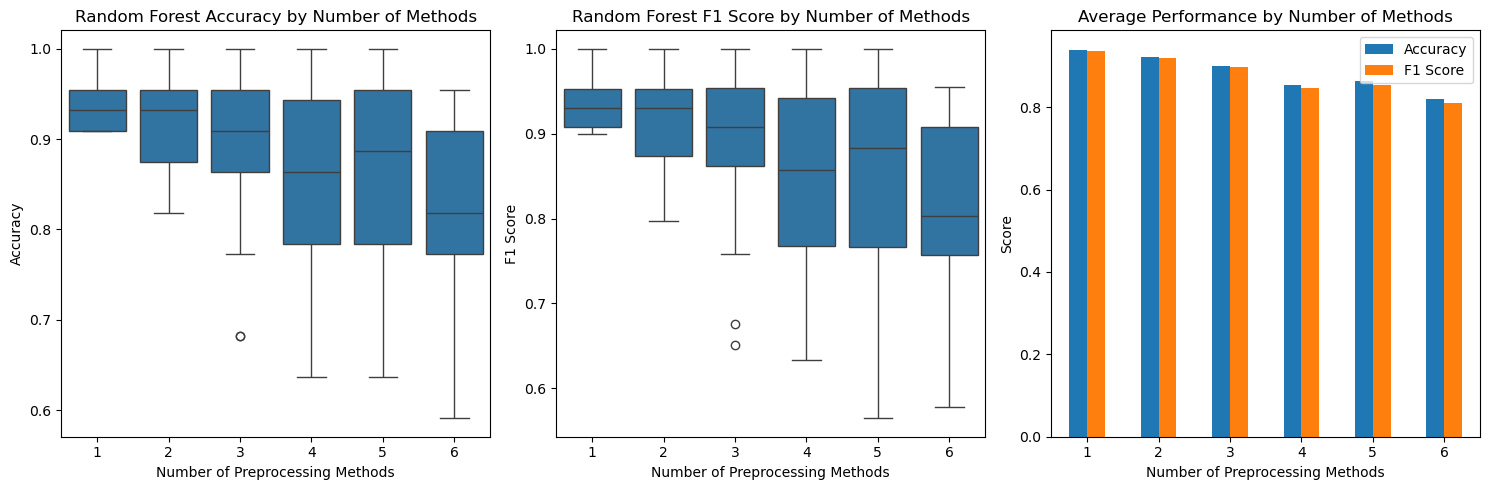

In [ ]:
# 조합 개수별 성능 분석
plt.figure(figsize=(15, 5))

# 조합 개수별 Random Forest 성능
plt.subplot(1, 3, 1)
sns.boxplot(data=df_results, x='num_methods', y='rf_accuracy')
plt.title('Random Forest Accuracy by Number of Methods')
plt.xlabel('Number of Preprocessing Methods')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_results, x='num_methods', y='rf_f1')
plt.title('Random Forest F1 Score by Number of Methods')
plt.xlabel('Number of Preprocessing Methods')
plt.ylabel('F1 Score')

# 조합 개수별 평균 성능
plt.subplot(1, 3, 3)
avg_by_num = df_results.groupby('num_methods')[['rf_accuracy', 'rf_f1']].mean()
avg_by_num.plot(kind='bar', ax=plt.gca())
plt.title('Average Performance by Number of Methods')
plt.xlabel('Number of Preprocessing Methods')
plt.ylabel('Score')
plt.legend(['Accuracy', 'F1 Score'])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

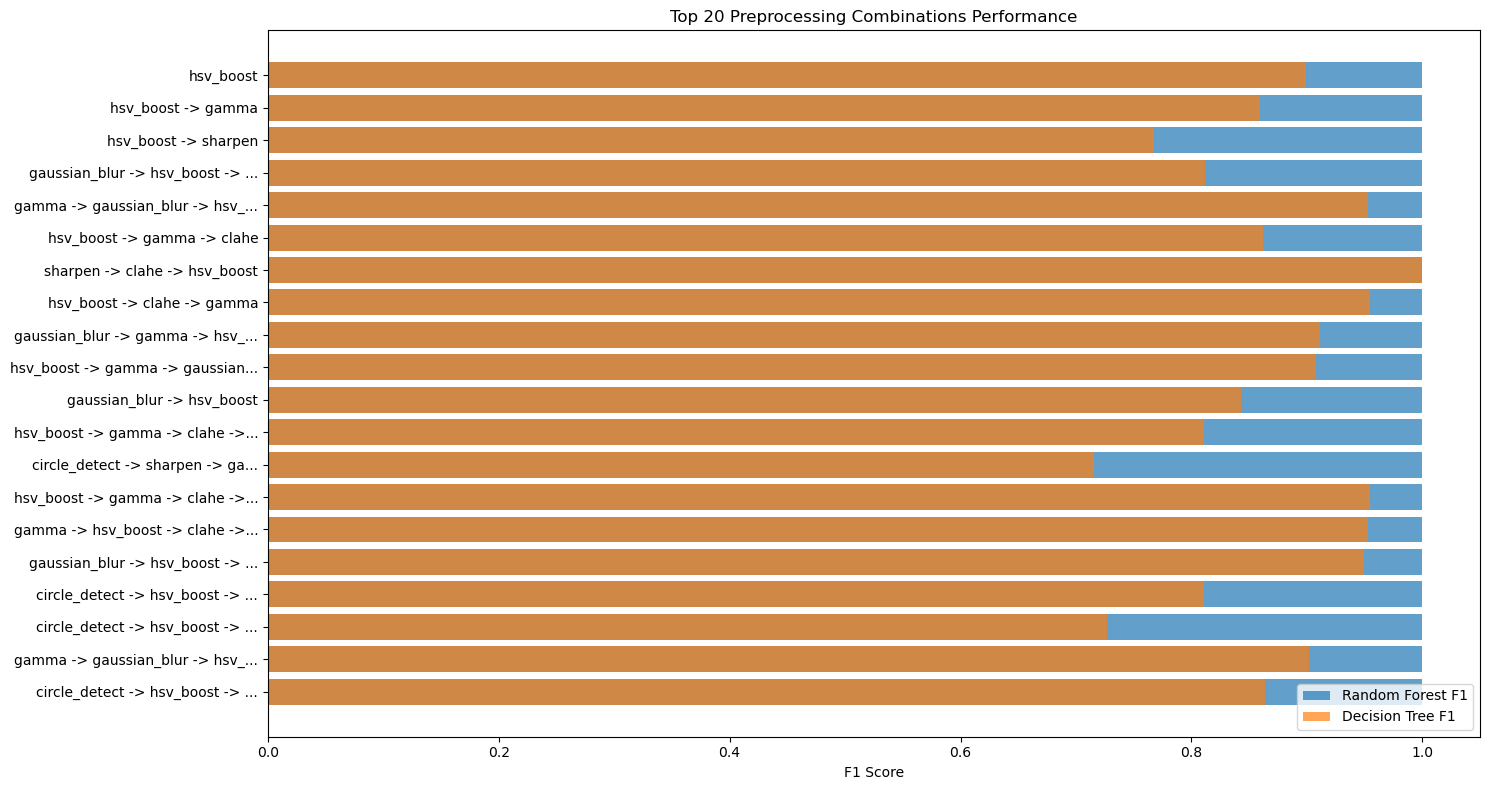

In [ ]:
# 상위 20개 조합 시각화
top_20 = df_results.head(20)

plt.figure(figsize=(15, 8))
x_pos = np.arange(len(top_20))

plt.barh(x_pos, top_20['rf_f1'], alpha=0.7, label='Random Forest F1')
plt.barh(x_pos, top_20['dt_f1'], alpha=0.7, label='Decision Tree F1')

plt.yticks(x_pos, [combo[:30] + '...' if len(combo) > 30 else combo for combo in top_20['combination']])
plt.xlabel('F1 Score')
plt.title('Top 20 Preprocessing Combinations Performance')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 가우시안 블러 포함 조합 분석

=== 가우시안 블러 포함 vs 미포함 성능 비교 ===
가우시안 블러 포함 조합 수: 111
가우시안 블러 미포함 조합 수: 100

평균 성능 (Random Forest):
  가우시안 블러 포함 - Accuracy: 0.8698, F1: 0.8634
  가우시안 블러 미포함 - Accuracy: 0.8814, F1: 0.8745


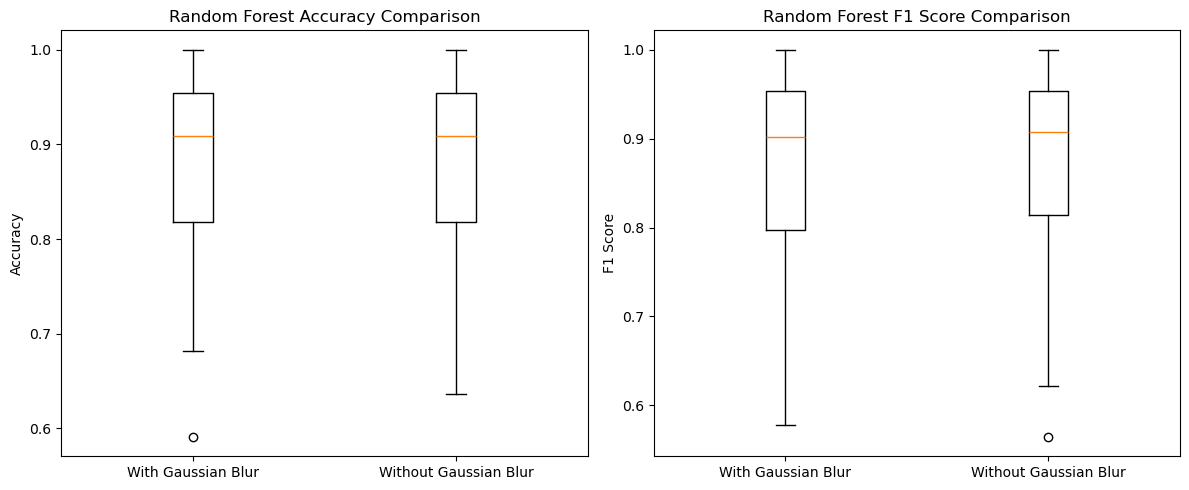

In [ ]:
# 가우시안 블러 포함 조합들 분석
gaussian_results = df_results[df_results['combination'].str.contains('gaussian_blur')]
non_gaussian_results = df_results[~df_results['combination'].str.contains('gaussian_blur')]

print("=== 가우시안 블러 포함 vs 미포함 성능 비교 ===")
print(f"가우시안 블러 포함 조합 수: {len(gaussian_results)}")
print(f"가우시안 블러 미포함 조합 수: {len(non_gaussian_results)}")
print()
print("평균 성능 (Random Forest):")
print(f"  가우시안 블러 포함 - Accuracy: {gaussian_results['rf_accuracy'].mean():.4f}, F1: {gaussian_results['rf_f1'].mean():.4f}")
print(f"  가우시안 블러 미포함 - Accuracy: {non_gaussian_results['rf_accuracy'].mean():.4f}, F1: {non_gaussian_results['rf_f1'].mean():.4f}")

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
data_to_plot = [gaussian_results['rf_accuracy'], non_gaussian_results['rf_accuracy']]
plt.boxplot(data_to_plot, labels=['With Gaussian Blur', 'Without Gaussian Blur'])
plt.title('Random Forest Accuracy Comparison')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
data_to_plot = [gaussian_results['rf_f1'], non_gaussian_results['rf_f1']]
plt.boxplot(data_to_plot, labels=['With Gaussian Blur', 'Without Gaussian Blur'])
plt.title('Random Forest F1 Score Comparison')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

## 최고 성능 조합 상세 분석

In [ ]:
# 최고 성능 조합
best_combination = df_results.iloc[0]

print("=== 최고 성능 전처리 조합 ===")
print(f"조합: {best_combination['combination']}")
print(f"Random Forest - Accuracy: {best_combination['rf_accuracy']:.4f}, F1: {best_combination['rf_f1']:.4f}")
print(f"Decision Tree - Accuracy: {best_combination['dt_accuracy']:.4f}, F1: {best_combination['dt_f1']:.4f}")
print(f"사용된 전처리 방법 수: {best_combination['num_methods']}")

# 상위 5개 조합 표
print("\n=== 상위 5개 조합 ===")
top_5 = df_results.head(5)
display_cols = ['combination', 'rf_accuracy', 'rf_f1', 'dt_accuracy', 'dt_f1', 'num_methods']
print(top_5[display_cols].to_string(index=False))

=== 최고 성능 전처리 조합 ===
조합: hsv_boost
Random Forest - Accuracy: 1.0000, F1: 1.0000
Decision Tree - Accuracy: 0.9091, F1: 0.8990
사용된 전처리 방법 수: 1

=== 상위 5개 조합 ===
                          combination  rf_accuracy  rf_f1  dt_accuracy    dt_f1  num_methods
                            hsv_boost          1.0    1.0     0.909091 0.899038            1
                   hsv_boost -> gamma          1.0    1.0     0.863636 0.859091            2
                 hsv_boost -> sharpen          1.0    1.0     0.772727 0.767308            2
gaussian_blur -> hsv_boost -> sharpen          1.0    1.0     0.818182 0.811966            3
  gamma -> gaussian_blur -> hsv_boost          1.0    1.0     0.954545 0.952991            3


## 결과 저장

In [ ]:
# 결과를 CSV 파일로 저장
if 'df_results' in globals() and len(df_results) > 0:
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'preprocessing_combination_results_{timestamp}.csv'
    
    try:
        df_results.to_csv(filename, index=False)
        print(f"결과가 '{filename}' 파일로 저장되었습니다.")
    except PermissionError:
        print("⚠️  CSV 파일 저장 권한 오류 발생. 다른 경로에 저장을 시도합니다.")
        try:
            import os
            desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", filename)
            df_results.to_csv(desktop_path, index=False)
            print(f"결과가 바탕화면에 '{filename}' 파일로 저장되었습니다.")
        except:
            print("파일 저장에 실패했습니다. 결과는 메모리에 df_results 변수로 저장되어 있습니다.")

    # 요약 통계
    print("\n=== 실험 요약 ===")
    print(f"총 테스트된 조합 수: {len(df_results)} / {len(all_combinations)} (전체)")
    print(f"테스트 비율: {len(df_results)/len(all_combinations)*100:.1f}%")
    print(f"최고 Random Forest 성능: {df_results['rf_f1'].max():.4f} (F1 Score)")
    print(f"최고 Decision Tree 성능: {df_results['dt_f1'].max():.4f} (F1 Score)")
    
    # 가우시안 블러 분석
    gaussian_results = df_results[df_results['combination'].str.contains('gaussian_blur')]
    non_gaussian_results = df_results[~df_results['combination'].str.contains('gaussian_blur')]
    print(f"가우시안 블러 포함 조합: {len(gaussian_results)}개 ({len(gaussian_results)/len(df_results)*100:.1f}%)")

    # 조합 개수별 최고 성능
    print("\n조합 개수별 최고 성능 (Random Forest F1):")
    for num in sorted(df_results['num_methods'].unique()):
        subset = df_results[df_results['num_methods'] == num]
        best_in_group = subset.loc[subset['rf_f1'].idxmax()]
        print(f"  {num}개 조합: {best_in_group['rf_f1']:.4f} - {best_in_group['combination']}")
        print(f"    (테스트된 {num}개 조합 수: {len(subset)}개)")
    
    # 현재 테스트 상태 확인
    print(f"\n=== 현재 테스트 상태 ===")
    expected_counts = {1: 6, 2: 30, 3: 120, 4: 360, 5: 720, 6: 720}
    actual_counts = df_results['num_methods'].value_counts().sort_index()
    
    print("길이별 조합 수 (테스트된 / 전체):")
    for length in range(1, 7):
        tested = actual_counts.get(length, 0)
        total = expected_counts[length]
        percentage = (tested / total * 100) if total > 0 else 0
        print(f"  {length}개 조합: {tested} / {total} ({percentage:.1f}%)")
    
    if len(df_results) < len(all_combinations):
        print(f"\n⚠️  전체 {len(all_combinations)}개 조합 중 {len(df_results)}개만 테스트되었습니다.")
        print("전체 순열을 테스트하려면 이전 셀에서 FULL_TEST = True로 설정하고 다시 실행하세요.")
    
    # *** 순열 효과 분석 (테스트된 조합에 대해서만) ***
    print("\n=== 순열 효과 분석 ===")
    
    # 같은 전처리 방법들을 사용하지만 순서가 다른 조합들 분석
    def get_method_set(combination_str):
        methods = combination_str.split(' -> ')
        return tuple(sorted(methods))
    
    df_results['method_set'] = df_results['combination'].apply(get_method_set)
    
    # 같은 방법들로 이루어진 그룹별 순서 효과 분석
    order_effects = []
    method_groups = df_results.groupby('method_set')
    
    for method_set, group in method_groups:
        if len(group) > 1:  # 순서가 다른 조합이 2개 이상인 경우만
            rf_f1_std = group['rf_f1'].std()
            rf_f1_range = group['rf_f1'].max() - group['rf_f1'].min()
            
            if rf_f1_range > 0.01:  # 의미 있는 차이가 있는 경우
                order_effects.append({
                    'methods': ' + '.join(method_set),
                    'num_orders': len(group),
                    'best_f1': group['rf_f1'].max(),
                    'worst_f1': group['rf_f1'].min(),
                    'f1_range': rf_f1_range,
                    'f1_std': rf_f1_std,
                    'best_order': group.loc[group['rf_f1'].idxmax(), 'combination'],
                    'worst_order': group.loc[group['rf_f1'].idxmin(), 'combination']
                })
    
    if order_effects:
        order_df = pd.DataFrame(order_effects).sort_values('f1_range', ascending=False)
        print(f"\n순서 효과가 발견된 방법 조합: {len(order_df)}개")
        print("순서 효과가 큰 상위 10개 방법 조합:")
        display_df = order_df.head(10)[['methods', 'f1_range', 'best_order', 'worst_order']]
        print(display_df.to_string(index=False))
        
        # 순서 효과 통계
        print(f"\n평균 F1 점수 차이: {order_df['f1_range'].mean():.4f}")
        print(f"최대 F1 점수 차이: {order_df['f1_range'].max():.4f}")
    else:
        print("순서 효과가 의미 있게 나타난 조합이 없습니다.")
    
    # 전처리 방법별 위치 효과 분석
    print("\n=== 전처리 방법별 위치 효과 분석 ===")
    position_effects = {}
    
    for method in methods:
        method_positions = {'first': [], 'middle': [], 'last': []}
        
        for _, row in df_results.iterrows():
            combo_methods = row['combination'].split(' -> ')
            if method in combo_methods:
                pos = combo_methods.index(method)
                if pos == 0:
                    method_positions['first'].append(row['rf_f1'])
                elif pos == len(combo_methods) - 1:
                    method_positions['last'].append(row['rf_f1'])
                else:
                    method_positions['middle'].append(row['rf_f1'])
        
        # 각 위치별 평균 성능 계산
        pos_stats = {}
        for pos, scores in method_positions.items():
            if scores:
                pos_stats[pos] = {
                    'mean': np.mean(scores),
                    'count': len(scores)
                }
        
        if len(pos_stats) > 1:  # 여러 위치에서 사용된 경우만
            position_effects[method] = pos_stats
    
    for method, stats in position_effects.items():
        print(f"\n{method}:")
        for pos, stat in stats.items():
            print(f"  {pos}: 평균 F1 = {stat['mean']:.4f} (사용 횟수: {stat['count']})")

else:
    print("⚠️  분석할 결과가 없습니다. 먼저 성능 평가를 실행해 주세요.")

PermissionError: [Errno 13] Permission denied: 'preprocessing_combination_results.csv'

In [ ]:
# 순열 효과 시각화
if 'df_results' in globals() and len(df_results) > 0:
    
    # 1. 조합 길이별 성능 분포 (더 상세하게)
    plt.figure(figsize=(18, 12))
    
    # 조합 길이별 박스플롯
    plt.subplot(2, 3, 1)
    sns.boxplot(data=df_results, x='num_methods', y='rf_f1')
    plt.title('Random Forest F1 Score Distribution by Combination Length')
    plt.xlabel('Number of Preprocessing Methods')
    plt.ylabel('F1 Score')
    
    # 조합 길이별 평균 성능 트렌드
    plt.subplot(2, 3, 2)
    length_stats = df_results.groupby('num_methods')['rf_f1'].agg(['mean', 'std', 'count'])
    plt.errorbar(length_stats.index, length_stats['mean'], yerr=length_stats['std'], 
                marker='o', capsize=5)
    plt.title('Average Performance Trend by Combination Length')
    plt.xlabel('Number of Preprocessing Methods')
    plt.ylabel('Average F1 Score')
    plt.grid(True, alpha=0.3)
    
    # 가우시안 블러 위치별 성능
    plt.subplot(2, 3, 3)
    gaussian_position_data = []
    for _, row in df_results[df_results['combination'].str.contains('gaussian_blur')].iterrows():
        combo_methods = row['combination'].split(' -> ')
        gaussian_pos = combo_methods.index('gaussian_blur')
        gaussian_position_data.append({
            'position': gaussian_pos,
            'total_length': len(combo_methods),
            'relative_position': gaussian_pos / (len(combo_methods) - 1) if len(combo_methods) > 1 else 0,
            'rf_f1': row['rf_f1']
        })
    
    if gaussian_position_data:
        pos_df = pd.DataFrame(gaussian_position_data)
        # 상대적 위치별 성능 (0=첫번째, 1=마지막)
        sns.scatterplot(data=pos_df, x='relative_position', y='rf_f1', alpha=0.6)
        plt.title('Gaussian Blur Performance by Relative Position')
        plt.xlabel('Relative Position (0=First, 1=Last)')
        plt.ylabel('F1 Score')
        plt.grid(True, alpha=0.3)
    
    # 상위 성능 조합들의 길이 분포
    plt.subplot(2, 3, 4)
    top_20_percent = df_results.head(int(len(df_results) * 0.2))
    length_counts = top_20_percent['num_methods'].value_counts().sort_index()
    plt.bar(length_counts.index, length_counts.values)
    plt.title('Top 20% Combinations - Length Distribution')
    plt.xlabel('Number of Preprocessing Methods')
    plt.ylabel('Count')
    
    # 각 전처리 방법이 포함된 비율 (상위 vs 전체)
    plt.subplot(2, 3, 5)
    method_inclusion = {}
    top_10_percent = df_results.head(int(len(df_results) * 0.1))
    
    for method in methods:
        total_inclusion = df_results['combination'].str.contains(method).mean()
        top_inclusion = top_10_percent['combination'].str.contains(method).mean()
        method_inclusion[method] = {
            'total': total_inclusion,
            'top_10': top_inclusion,
            'ratio': top_inclusion / total_inclusion if total_inclusion > 0 else 0
        }
    
    method_names = list(method_inclusion.keys())
    total_rates = [method_inclusion[m]['total'] for m in method_names]
    top_rates = [method_inclusion[m]['top_10'] for m in method_names]
    
    x = np.arange(len(method_names))
    width = 0.35
    
    plt.bar(x - width/2, total_rates, width, label='All Combinations', alpha=0.7)
    plt.bar(x + width/2, top_rates, width, label='Top 10%', alpha=0.7)
    plt.xlabel('Preprocessing Methods')
    plt.ylabel('Inclusion Rate')
    plt.title('Method Inclusion Rate: All vs Top 10%')
    plt.xticks(x, method_names, rotation=45)
    plt.legend()
    
    # 순서 효과가 큰 조합들 시각화
    plt.subplot(2, 3, 6)
    if 'order_df' in locals() and len(order_df) > 0:
        top_order_effects = order_df.head(10)
        plt.barh(range(len(top_order_effects)), top_order_effects['f1_range'])
        plt.yticks(range(len(top_order_effects)), 
                  [methods[:20] + '...' if len(methods) > 20 else methods 
                   for methods in top_order_effects['methods']])
        plt.xlabel('F1 Score Range (Best - Worst Order)')
        plt.title('Top 10 Method Sets with Largest Order Effects')
        plt.gca().invert_yaxis()
    else:
        plt.text(0.5, 0.5, 'No significant order effects found', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Order Effects Analysis')
    
    plt.tight_layout()
    plt.show()
    
    print("🎯 순열 효과 분석 완료!")
    print(f"📊 총 {len(df_results)}개 조합 중 상위 10% 조합에서 자주 사용되는 방법:")
    
    # 상위 조합에서 선호되는 방법 순위
    method_preference = sorted(method_inclusion.items(), 
                              key=lambda x: x[1]['ratio'], reverse=True)
    for i, (method, stats) in enumerate(method_preference[:3]):
        print(f"  {i+1}. {method}: 상위 조합 포함률 {stats['top_10']:.2%} (전체 대비 {stats['ratio']:.1f}배)")

else:
    print("⚠️  분석할 결과가 없습니다.")